### **Project 3 : Image Classification**

### **Nama : Fakhrur Novianto**

### **Asal : Tangerang**

### **Data : Intel Image Classification**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# import data gambar dari Kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"fakhrurnovianto","key":"e4b2926a232922a289f5e31975dbfd58"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Oct 27 23:49 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip intel-image-classification.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain

In [ ]:
!ls seg_train/seg_train/

buildings  forest  glacier  mountain  sea  street


In [ ]:
import os

data = os.path.join('/content/seg_train/seg_train')
print(os.listdir(data))

['glacier', 'sea', 'street', 'forest', 'buildings', 'mountain']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 20,
                horizontal_flip = True,
                shear_range = 0.2,               
                fill_mode = 'nearest',
                validation_split = 0.2)


In [ ]:
train_generator = train_datagen.flow_from_directory(
                  data,
                  target_size = (150, 150),
                  batch_size = 10,
                  class_mode = 'categorical',
                  subset = 'training') # Dicari yang maksimum

vali_generator = train_datagen.flow_from_directory(
                  data,
                  target_size = (150, 150),
                  batch_size = 10,
                  class_mode = 'categorical',
                  subset = 'validation') # Dicari yang maksimum

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import MobileNetV2
import pathlib

In [ ]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))
 
for layer in pre_trained_model.layers:
    layer.trainable = False
 
last_output = pre_trained_model.output

x = Sequential([Conv2D(64, (3,3), activation = 'relu', input_shape =(150, 150, 3))])
x = MaxPooling2D(2, 2)
x = Flatten(name="flatten")(last_output)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dense(6, activation='softmax')(x)
 
model = tf.keras.models.Model(pre_trained_model.input, x)


int_lr = 1e-4
num_epochs = 30
 
optimizer = tf.optimizers.Nadam(lr=int_lr)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [ ]:
#------------------------------------------------------------------------------


#model = Sequential([Conv2D(64, (3,3), activation = 'relu', input_shape =(150, 150, 3)),
#                    MaxPooling2D(2,2),
#                    # Hidden Layer 1
#                    Conv2D(64, (3,3), activation = 'relu'),
#                    MaxPooling2D(2, 2),
#                    # Hidden Layer 2
#                    # Hidden Layer 1
#                    Conv2D(128, (3,3), activation = 'relu'),
#                    MaxPooling2D(2, 2),
                    
#                    Flatten(),
#                   Dense(512, activation = 'relu'),
#                    Dense(6, activation = 'softmax')])


#------------------------------------------------------------------------------

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              #optimizer = tf.optimizers.Nadam(),
              metrics = ['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_8[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
from keras.callbacks import Callback

class batas(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      self.model.stop_training = True
      print('\nAkurasi Train dan Validasi sudah melbihi 80%')
      
callbacks = batas()

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples//100,
                    epochs = 50,
                    validation_data = vali_generator,
                    validation_steps = 5,
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/50
112/112 - 11s - loss: 0.8941 - accuracy: 0.7286 - val_loss: 0.6491 - val_accuracy: 0.8400 - 11s/epoch - 96ms/step
Epoch 2/50
112/112 - 6s - loss: 0.5257 - accuracy: 0.8393 - val_loss: 0.4161 - val_accuracy: 0.8400 - 6s/epoch - 58ms/step
Epoch 3/50
112/112 - 6s - loss: 0.4608 - accuracy: 0.8446 - val_loss: 0.6978 - val_accuracy: 0.8400 - 6s/epoch - 57ms/step
Epoch 4/50
112/112 - 6s - loss: 0.3595 - accuracy: 0.8705 - val_loss: 0.3437 - val_accuracy: 0.9000 - 6s/epoch - 57ms/step
Epoch 5/50
112/112 - 6s - loss: 0.3955 - accuracy: 0.8580 - val_loss: 0.3836 - val_accuracy: 0.8800 - 6s/epoch - 58ms/step
Epoch 6/50
112/112 - 6s - loss: 0.3956 - accuracy: 0.8696 - val_loss: 0.3021 - val_accuracy: 0.8400 - 6s/epoch - 58ms/step
Epoch 7/50
112/112 - 8s - loss: 0.3554 - accuracy: 0.8723 - val_loss: 0.3041 - val_accuracy: 0.8600 - 8s/epoch - 69ms/step
Epoch 8/50
112/112 - 6s - loss: 0.3386 - accuracy: 0.8813 - val_loss: 0.2175 - val_accuracy: 0.9000 - 6s/epoch - 58ms/step
Epoch 9/50
112

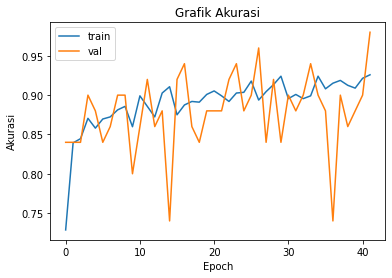

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Grafik Akurasi')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

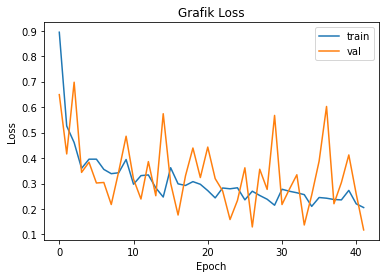

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Grafik Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

25247864